# 1. Import libraries


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import warnings
warnings.filterwarnings('ignore')

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

# Imbalanced data handling
from imblearn.over_sampling import SMOTE

# Save/Load
import pickle
import json
from datetime import datetime

# Download NLTK data (run once)
try:
    nltk.data.find('corpora/stopwords')
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('stopwords')
    nltk.download('punkt_tab')
    nltk.download('wordnet')
    nltk.download('omw-1.4')

print("✅ All libraries imported successfully")
print(f"Preprocessing started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ahmed\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Ahmed\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ahmed\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Ahmed\AppData\Roaming\nltk_data...


✅ All libraries imported successfully
Preprocessing started at: 2026-02-14 21:49:05


# 2. Load dataset


In [9]:
print("="*80)
print("LOADING DATASET")
print("="*80)

df = pd.read_csv('../Data/raw/fake_job_postings.csv')

print(f"Original Dataset Shape: {df.shape}")
print(f"Total Rows: {len(df):,}")
print(f"Total Features: {df.shape[1]}")
print(f"\nTarget Distribution:")
print(df['fraudulent'].value_counts())
print(f"Fraud Percentage: {df['fraudulent'].mean() * 100:.2f}%")

# Display first few rows
df.head()

LOADING DATASET
Original Dataset Shape: (17880, 18)
Total Rows: 17,880
Total Features: 18

Target Distribution:
fraudulent
0    17014
1      866
Name: count, dtype: int64
Fraud Percentage: 4.84%


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


# 3. Handle missing values


In [10]:
print("="*80)
print("HANDLING MISSING VALUES")
print("="*80)

# Check missing values before
missing_before = df.isnull().sum()
print("\nMissing Values Before:")
print(missing_before[missing_before > 0])

# Strategy:
# - Text columns: Fill with empty string
# - Categorical: Fill with 'Unknown'
# - Boolean: Fill with 0 (False)

text_columns = ['title', 'location', 'department', 'salary_range', 
                'company_profile', 'description', 'requirements', 
                'benefits', 'employment_type', 'required_experience', 
                'required_education', 'industry', 'function']

for col in text_columns:
    if col in df.columns:
        df[col] = df[col].fillna('Unknown' if col in ['employment_type', 'required_experience', 
                                                        'required_education', 'industry', 
                                                        'function', 'department'] else '')

# Fill boolean columns
boolean_columns = ['telecommuting', 'has_company_logo', 'has_questions']
for col in boolean_columns:
    if col in df.columns:
        df[col] = df[col].fillna(0).astype(int)

# Check missing values after
missing_after = df.isnull().sum()
print("\nMissing Values After:")
print(missing_after[missing_after > 0])

if missing_after.sum() == 0:
    print("\n✅ All missing values handled successfully!")
else:
    print(f"\n⚠️ Still {missing_after.sum()} missing values remaining")

print(f"\nDataset shape after handling missing values: {df.shape}")

HANDLING MISSING VALUES

Missing Values Before:
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
dtype: int64

Missing Values After:
Series([], dtype: int64)

✅ All missing values handled successfully!

Dataset shape after handling missing values: (17880, 18)


# 4. Define text preprocessing functions


In [11]:
print("="*80)
print("DEFINING TEXT PREPROCESSING FUNCTIONS")
print("="*80)

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    """
    Comprehensive text cleaning pipeline
    """
    if not isinstance(text, str) or text == '':
        return ''
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove special characters and digits (keep only letters and spaces)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text

def preprocess_text(text):
    """
    Advanced preprocessing: tokenize, remove stopwords, lemmatize
    """
    if not isinstance(text, str) or text == '':
        return ''
    
    # Clean text
    text = clean_text(text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens 
              if word not in stop_words and len(word) > 2]
    
    return ' '.join(tokens)

# Test the functions
test_text = "This is a GREAT opportunity! Visit http://example.com or email us at jobs@fake.com. Salary: $50,000-$70,000."
print("\nOriginal Text:")
print(test_text)
print("\nCleaned Text:")
print(clean_text(test_text))
print("\nPreprocessed Text:")
print(preprocess_text(test_text))

print("\n✅ Text preprocessing functions defined successfully")

DEFINING TEXT PREPROCESSING FUNCTIONS

Original Text:
This is a GREAT opportunity! Visit http://example.com or email us at jobs@fake.com. Salary: $50,000-$70,000.

Cleaned Text:
this is a great opportunity visit or email us at salary

Preprocessed Text:
great opportunity visit email salary

✅ Text preprocessing functions defined successfully


# 5. Combine and preprocess text features


In [12]:
print("="*80)
print("COMBINING AND PREPROCESSING TEXT FEATURES")
print("="*80)

# Combine all text columns into one feature
print("Combining text columns: title, company_profile, description, requirements, benefits")

df['full_text_raw'] = (
    df['title'].fillna('') + ' ' +
    df['company_profile'].fillna('') + ' ' +
    df['description'].fillna('') + ' ' +
    df['requirements'].fillna('') + ' ' +
    df['benefits'].fillna('')
)

print(f"Created 'full_text_raw' column with {df['full_text_raw'].str.len().sum():,} total characters")

# Apply preprocessing
print("\nApplying text preprocessing (this may take a few minutes)...")
import time
start_time = time.time()

df['full_text_clean'] = df['full_text_raw'].apply(preprocess_text)

end_time = time.time()
print(f"✅ Text preprocessing completed in {end_time - start_time:.2f} seconds")

# Show example
print("\n" + "="*80)
print("EXAMPLE: Before and After Preprocessing")
print("="*80)
sample_idx = df[df['full_text_raw'].str.len() > 500].index[0]

print(f"\nOriginal Text (first 500 chars):")
print(df.loc[sample_idx, 'full_text_raw'][:500])
print(f"\nPreprocessed Text (first 500 chars):")
print(df.loc[sample_idx, 'full_text_clean'][:500])

# Check for empty texts after preprocessing
empty_texts = (df['full_text_clean'].str.strip() == '').sum()
print(f"\n⚠️ Rows with empty text after preprocessing: {empty_texts}")

if empty_texts > 0:
    # Fill empty with placeholder
    df.loc[df['full_text_clean'].str.strip() == '', 'full_text_clean'] = 'no information available'
    print("✅ Empty texts filled with placeholder")

COMBINING AND PREPROCESSING TEXT FEATURES
Combining text columns: title, company_profile, description, requirements, benefits
Created 'full_text_raw' column with 47,747,898 total characters

Applying text preprocessing (this may take a few minutes)...
✅ Text preprocessing completed in 40.14 seconds

EXAMPLE: Before and After Preprocessing

Original Text (first 500 chars):
Marketing Intern We're Food52, and we've created a groundbreaking and award-winning cooking site. We support, connect, and celebrate home cooks, and give them everything they need in one place.We have a top editorial, business, and engineering team. We're focused on using technology to find new and better ways to connect people around their specific food interests, and to offer them superb, highly curated information about food and cooking. We attract the most talented home cooks and contributor

Preprocessed Text (first 500 chars):
marketing intern food weve created groundbreaking awardwinning cooking site support co

# 6. Feature engineering - Text-based features


In [13]:
print("="*80)
print("FEATURE ENGINEERING - TEXT FEATURES")
print("="*80)

# Length features
df['text_length'] = df['full_text_raw'].str.len()
df['word_count'] = df['full_text_raw'].str.split().str.len()
df['char_count'] = df['full_text_raw'].str.len()
df['avg_word_length'] = df['char_count'] / (df['word_count'] + 1)  # +1 to avoid division by zero

# Specific text field lengths
df['title_length'] = df['title'].str.len()
df['description_length'] = df['description'].str.len()
df['requirements_length'] = df['requirements'].str.len()
df['benefits_length'] = df['benefits'].str.len()
df['company_profile_length'] = df['company_profile'].str.len()

# Pattern detection features
df['has_email'] = df['full_text_raw'].str.contains(r'\S+@\S+', regex=True).astype(int)
df['has_url'] = df['full_text_raw'].str.contains(r'http|www', regex=True, case=False).astype(int)
df['has_phone'] = df['full_text_raw'].str.contains(r'\d{3}[-\.\s]?\d{3}[-\.\s]?\d{4}', regex=True).astype(int)

# Uppercase ratio (fake jobs might use excessive caps)
df['uppercase_ratio'] = df['full_text_raw'].apply(
    lambda x: sum(1 for c in x if c.isupper()) / (len(x) + 1)
)

# Special character count
df['special_char_count'] = df['full_text_raw'].apply(
    lambda x: sum(1 for c in x if c in string.punctuation)
)

# Exclamation marks (fake jobs might be overly enthusiastic)
df['exclamation_count'] = df['full_text_raw'].str.count('!')

print("Created text-based features:")
new_features = ['text_length', 'word_count', 'char_count', 'avg_word_length',
                'title_length', 'description_length', 'requirements_length', 
                'benefits_length', 'company_profile_length',
                'has_email', 'has_url', 'has_phone', 'uppercase_ratio', 
                'special_char_count', 'exclamation_count']

for feature in new_features:
    print(f"  - {feature}")

# Display statistics
print("\n" + "="*80)
print("TEXT FEATURE STATISTICS: Real vs Fake")
print("="*80)

comparison_features = ['text_length', 'word_count', 'has_email', 'has_url', 
                       'exclamation_count', 'uppercase_ratio']

for feature in comparison_features:
    real_mean = df[df['fraudulent'] == 0][feature].mean()
    fake_mean = df[df['fraudulent'] == 1][feature].mean()
    print(f"\n{feature}:")
    print(f"  Real jobs: {real_mean:.2f}")
    print(f"  Fake jobs: {fake_mean:.2f}")
    print(f"  Difference: {abs(real_mean - fake_mean):.2f}")

FEATURE ENGINEERING - TEXT FEATURES
Created text-based features:
  - text_length
  - word_count
  - char_count
  - avg_word_length
  - title_length
  - description_length
  - requirements_length
  - benefits_length
  - company_profile_length
  - has_email
  - has_url
  - has_phone
  - uppercase_ratio
  - special_char_count
  - exclamation_count

TEXT FEATURE STATISTICS: Real vs Fake

text_length:
  Real jobs: 2700.59
  Fake jobs: 2078.64
  Difference: 621.95

word_count:
  Real jobs: 379.49
  Fake jobs: 282.33
  Difference: 97.16

has_email:
  Real jobs: 0.01
  Fake jobs: 0.00
  Difference: 0.01

has_url:
  Real jobs: 0.02
  Fake jobs: 0.01
  Difference: 0.01

exclamation_count:
  Real jobs: 0.67
  Fake jobs: 0.55
  Difference: 0.11

uppercase_ratio:
  Real jobs: 0.04
  Fake jobs: 0.05
  Difference: 0.01


# 7. Encode categorical features


In [14]:
print("="*80)
print("ENCODING CATEGORICAL FEATURES")
print("="*80)

categorical_columns = ['employment_type', 'required_experience', 
                       'required_education', 'industry', 'function']

# Initialize label encoders dictionary
label_encoders = {}

# Encode each categorical column
for col in categorical_columns:
    print(f"\nEncoding: {col}")
    print(f"  Unique values: {df[col].nunique()}")
    
    le = LabelEncoder()
    df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
    
    print(f"  Encoded range: 0 to {df[f'{col}_encoded'].max()}")
    print(f"  Sample mapping: {dict(list(zip(le.classes_[:3], le.transform(le.classes_[:3])))[:3])}")

print(f"\n✅ Encoded {len(categorical_columns)} categorical features")

# Save label encoders for later use
import os
os.makedirs('../models/model_artifacts', exist_ok=True)

with open('../models/model_artifacts/label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

print("✅ Label encoders saved to: models/model_artifacts/label_encoders.pkl")

ENCODING CATEGORICAL FEATURES

Encoding: employment_type
  Unique values: 6
  Encoded range: 0 to 5
  Sample mapping: {'Contract': np.int64(0), 'Full-time': np.int64(1), 'Other': np.int64(2)}

Encoding: required_experience
  Unique values: 8
  Encoded range: 0 to 7
  Sample mapping: {'Associate': np.int64(0), 'Director': np.int64(1), 'Entry level': np.int64(2)}

Encoding: required_education
  Unique values: 14
  Encoded range: 0 to 13
  Sample mapping: {'Associate Degree': np.int64(0), "Bachelor's Degree": np.int64(1), 'Certification': np.int64(2)}

Encoding: industry
  Unique values: 132
  Encoded range: 0 to 131
  Sample mapping: {'Accounting': np.int64(0), 'Airlines/Aviation': np.int64(1), 'Alternative Dispute Resolution': np.int64(2)}

Encoding: function
  Unique values: 38
  Encoded range: 0 to 37
  Sample mapping: {'Accounting/Auditing': np.int64(0), 'Administrative': np.int64(1), 'Advertising': np.int64(2)}

✅ Encoded 5 categorical features
✅ Label encoders saved to: models/mode

# 8. Location feature engineering


In [15]:
print("="*80)
print("LOCATION FEATURE ENGINEERING")
print("="*80)

# Extract country/region from location
def extract_country(location):
    if not isinstance(location, str) or location == '':
        return 'Unknown'
    
    # Common patterns: "City, State, Country" or "City, Country"
    parts = [p.strip() for p in location.split(',')]
    
    if len(parts) >= 2:
        return parts[-1]  # Last part is usually country
    return location

df['country'] = df['location'].apply(extract_country)

# Top countries
top_countries = df['country'].value_counts().head(10)
print("\nTop 10 Countries/Regions:")
print(top_countries)

# Create binary features for top countries
print("\nCreating binary features for top 5 countries:")
for country in top_countries.head(5).index:
    feature_name = f'is_{country.lower().replace(" ", "_")}'
    df[feature_name] = (df['country'] == country).astype(int)
    print(f"  - {feature_name}")

# Location has information
df['has_location'] = (df['location'] != '').astype(int)

print(f"\n✅ Location features created")

LOCATION FEATURE ENGINEERING

Top 10 Countries/Regions:
country
                 1635
London           1098
New York          685
Athens            558
San Francisco     485
Unknown           346
Houston           273
Berlin            263
Chicago           258
Washington        255
Name: count, dtype: int64

Creating binary features for top 5 countries:
  - is_
  - is_london
  - is_new_york
  - is_athens
  - is_san_francisco

✅ Location features created


# 9. Create final feature set


In [16]:
print("="*80)
print("CREATING FINAL FEATURE SET")
print("="*80)

# Select features for modeling
feature_columns = [
    # Boolean features
    'telecommuting', 'has_company_logo', 'has_questions',
    
    # Text length features
    'text_length', 'word_count', 'avg_word_length',
    'title_length', 'description_length', 'requirements_length',
    'benefits_length', 'company_profile_length',
    
    # Pattern features
    'has_email', 'has_url', 'has_phone', 
    'uppercase_ratio', 'special_char_count', 'exclamation_count',
    
    # Encoded categorical features
    'employment_type_encoded', 'required_experience_encoded',
    'required_education_encoded', 'industry_encoded', 'function_encoded',
    
    # Location features
    'has_location'
]

# Add top country features
top_country_features = [col for col in df.columns if col.startswith('is_')]
feature_columns.extend(top_country_features)

print(f"Total features selected: {len(feature_columns)}")
print("\nFeature categories:")
print(f"  - Boolean: 3")
print(f"  - Text length: 9")
print(f"  - Pattern detection: 6")
print(f"  - Encoded categorical: 5")
print(f"  - Location: {1 + len(top_country_features)}")

# Create feature matrix
X = df[feature_columns].copy()
y = df['fraudulent'].copy()

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Check for any remaining NaN values
nan_counts = X.isnull().sum()
if nan_counts.sum() > 0:
    print("\n⚠️ Warning: NaN values found in features:")
    print(nan_counts[nan_counts > 0])
    X = X.fillna(0)
    print("✅ NaN values filled with 0")
else:
    print("\n✅ No NaN values in feature matrix")

# Display feature statistics
print("\n" + "="*80)
print("FEATURE STATISTICS")
print("="*80)
print(X.describe().T[['mean', 'std', 'min', 'max']])

CREATING FINAL FEATURE SET
Total features selected: 28

Feature categories:
  - Boolean: 3
  - Text length: 9
  - Pattern detection: 6
  - Encoded categorical: 5
  - Location: 6

Feature matrix shape: (17880, 28)
Target shape: (17880,)

✅ No NaN values in feature matrix

FEATURE STATISTICS
                                    mean          std        min           max
telecommuting                   0.042897     0.202631   0.000000      1.000000
has_company_logo                0.795302     0.403492   0.000000      1.000000
has_questions                   0.491723     0.499945   0.000000      1.000000
text_length                  2670.464094  1465.514148  18.000000  14945.000000
word_count                    374.785291   207.615353   2.000000   2118.000000
avg_word_length                 7.225349     1.618574   4.842105    100.233333
title_length                   28.530313    13.871256   3.000000    142.000000
description_length           1218.004418   894.828620   0.000000  14907.00000

# 10. Train-validation-test split


In [17]:
print("="*80)
print("TRAIN-VALIDATION-TEST SPLIT")
print("="*80)

# First split: separate test set (10%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

# Second split: separate train and validation (80% train, 10% val from remaining)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.111, random_state=42, stratify=y_temp  # 0.111 of 90% = 10% of total
)

print(f"Original dataset size: {len(X):,}")
print(f"\nTrain set: {len(X_train):,} ({len(X_train)/len(X)*100:.1f}%)")
print(f"  - Real: {(y_train == 0).sum():,}")
print(f"  - Fake: {(y_train == 1).sum():,}")
print(f"  - Fraud rate: {y_train.mean()*100:.2f}%")

print(f"\nValidation set: {len(X_val):,} ({len(X_val)/len(X)*100:.1f}%)")
print(f"  - Real: {(y_val == 0).sum():,}")
print(f"  - Fake: {(y_val == 1).sum():,}")
print(f"  - Fraud rate: {y_val.mean()*100:.2f}%")

print(f"\nTest set: {len(X_test):,} ({len(X_test)/len(X)*100:.1f}%)")
print(f"  - Real: {(y_test == 0).sum():,}")
print(f"  - Fake: {(y_test == 1).sum():,}")
print(f"  - Fraud rate: {y_test.mean()*100:.2f}%")

print("\n✅ Data split completed successfully")

TRAIN-VALIDATION-TEST SPLIT
Original dataset size: 17,880

Train set: 14,305 (80.0%)
  - Real: 13,613
  - Fake: 692
  - Fraud rate: 4.84%

Validation set: 1,787 (10.0%)
  - Real: 1,700
  - Fake: 87
  - Fraud rate: 4.87%

Test set: 1,788 (10.0%)
  - Real: 1,701
  - Fake: 87
  - Fraud rate: 4.87%

✅ Data split completed successfully


# 11. Handle class imbalance with SMOTE


HANDLING CLASS IMBALANCE WITH SMOTE
Before SMOTE:
  Training set size: 14,305
  Real jobs: 13,613
  Fake jobs: 692
  Imbalance ratio: 19.67:1

After SMOTE:
  Training set size: 27,226
  Real jobs: 13,613
  Fake jobs: 13,613
  Imbalance ratio: 1.00:1

✅ SMOTE applied successfully
⚠️ Note: SMOTE only applied to training set. Validation and test sets remain unchanged.


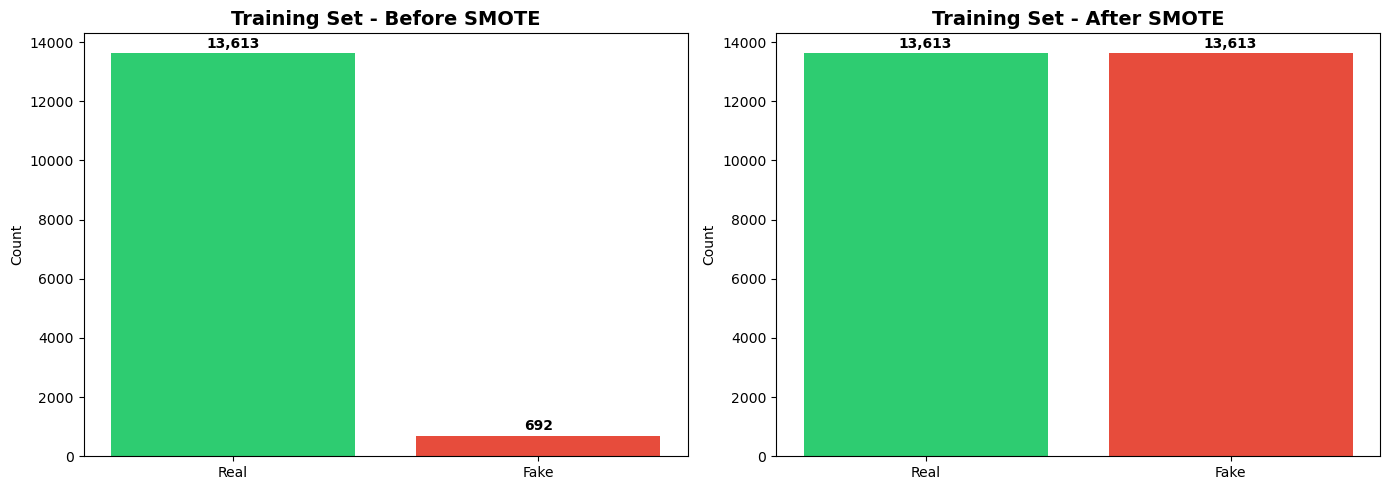

In [18]:
print("="*80)
print("HANDLING CLASS IMBALANCE WITH SMOTE")
print("="*80)

print("Before SMOTE:")
print(f"  Training set size: {len(X_train):,}")
print(f"  Real jobs: {(y_train == 0).sum():,}")
print(f"  Fake jobs: {(y_train == 1).sum():,}")
print(f"  Imbalance ratio: {(y_train == 0).sum() / (y_train == 1).sum():.2f}:1")

# Apply SMOTE only to training data
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("\nAfter SMOTE:")
print(f"  Training set size: {len(X_train_balanced):,}")
print(f"  Real jobs: {(y_train_balanced == 0).sum():,}")
print(f"  Fake jobs: {(y_train_balanced == 1).sum():,}")
print(f"  Imbalance ratio: {(y_train_balanced == 0).sum() / (y_train_balanced == 1).sum():.2f}:1")

print(f"\n✅ SMOTE applied successfully")
print(f"⚠️ Note: SMOTE only applied to training set. Validation and test sets remain unchanged.")

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before SMOTE
axes[0].bar(['Real', 'Fake'], [(y_train == 0).sum(), (y_train == 1).sum()], 
            color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Training Set - Before SMOTE', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')
for i, v in enumerate([(y_train == 0).sum(), (y_train == 1).sum()]):
    axes[0].text(i, v + 100, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# After SMOTE
axes[1].bar(['Real', 'Fake'], [(y_train_balanced == 0).sum(), (y_train_balanced == 1).sum()], 
            color=['#2ecc71', '#e74c3c'])
axes[1].set_title('Training Set - After SMOTE', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Count')
for i, v in enumerate([(y_train_balanced == 0).sum(), (y_train_balanced == 1).sum()]):
    axes[1].text(i, v + 100, f'{v:,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('../Data/delivrables/smote_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 12. Feature scaling


In [19]:
print("="*80)
print("FEATURE SCALING")
print("="*80)

# Initialize scaler
scaler = StandardScaler()

# Fit on balanced training data and transform all sets
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Scaler fitted on training data (balanced)")
print(f"\nFeature scaling statistics (from training data):")
print(f"  Mean: {scaler.mean_[:5]}... (first 5 features)")
print(f"  Std:  {scaler.scale_[:5]}... (first 5 features)")

# Convert back to DataFrames with column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=feature_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_columns)

print(f"\n✅ Feature scaling completed")
print(f"   - Training set: {X_train_scaled.shape}")
print(f"   - Validation set: {X_val_scaled.shape}")
print(f"   - Test set: {X_test_scaled.shape}")

# Save scaler
with open('../models/model_artifacts/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("✅ Scaler saved to: models/model_artifacts/scaler.pkl")

FEATURE SCALING
Scaler fitted on training data (balanced)

Feature scaling statistics (from training data):
  Mean: [4.18717402e-02 5.42863439e-01 3.28362595e-01 2.37802909e+03
 3.29415228e+02]... (first 5 features)
  Std:  [2.00296025e-01 4.98159338e-01 4.69617505e-01 1.51569377e+03
 2.09380618e+02]... (first 5 features)

✅ Feature scaling completed
   - Training set: (27226, 28)
   - Validation set: (1787, 28)
   - Test set: (1788, 28)
✅ Scaler saved to: models/model_artifacts/scaler.pkl


# 13. Prepare text data for deep learning models


In [20]:
print("="*80)
print("PREPARING TEXT DATA FOR NLP MODELS (BERT/Transformers)")
print("="*80)

# Get corresponding text data for each split
# We need to map indices back to get the preprocessed text

# Get indices for each split
train_indices = X_train.index
val_indices = X_val.index
test_indices = X_test.index

# Extract text data
text_train = df.loc[train_indices, 'full_text_clean'].values
text_val = df.loc[val_indices, 'full_text_clean'].values
text_test = df.loc[test_indices, 'full_text_clean'].values

print(f"Text data extracted:")
print(f"  - Training text samples: {len(text_train):,}")
print(f"  - Validation text samples: {len(text_val):,}")
print(f"  - Test text samples: {len(text_test):,}")

# For SMOTE balanced data, we need to handle duplicated texts
# Since SMOTE creates synthetic samples for features, but we can't synthesize text meaningfully,
# we'll use the original training text for now and rely on class_weight for text models

print(f"\n⚠️ Note: For BERT/Transformer models, use original training data with class_weight")
print(f"   Text cannot be meaningfully synthesized by SMOTE")

# Sample text
print("\n" + "="*80)
print("SAMPLE PREPROCESSED TEXT")
print("="*80)
print(f"\nExample 1 (Real job):")
real_idx = df[df['fraudulent'] == 0].index[0]
print(df.loc[real_idx, 'full_text_clean'][:300])

print(f"\nExample 2 (Fake job):")
fake_idx = df[df['fraudulent'] == 1].index[0]
print(df.loc[fake_idx, 'full_text_clean'][:300])

PREPARING TEXT DATA FOR NLP MODELS (BERT/Transformers)
Text data extracted:
  - Training text samples: 14,305
  - Validation text samples: 1,787
  - Test text samples: 1,788

⚠️ Note: For BERT/Transformer models, use original training data with class_weight
   Text cannot be meaningfully synthesized by SMOTE

SAMPLE PREPROCESSED TEXT

Example 1 (Real job):
marketing intern food weve created groundbreaking awardwinning cooking site support connect celebrate home cook give everything need one placewe top editorial business engineering team focused using technology find new better way connect people around specific food interest offer superb highly curat

Example 2 (Fake job):
ice technician staffing amp recruiting done right oil amp energy industryrepresented candidate automatically granted following perk expert negotiation behalf maximizing compensation package implimenting ongoing increase significant signing bonus refined resource addition potential signing bonus clie


# 14. Create TF-IDF features for traditional ML models


In [ ]:
print("="*80)
print("CREATING TF-IDF FEATURES")
print("="*80)

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    max_features=5000,      # Top 5000 features
    ngram_range=(1, 2),     # Unigrams and bigrams
    min_df=5,               # Minimum document frequency
    max_df=0.8,             # Maximum document frequency (remove too common words)
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    use_idf=True,
    smooth_idf=True,
    sublinear_tf=True
)

# Fit on training data and transform all sets
print("Fitting TF-IDF on training data...")
tfidf_train = tfidf.fit_transform(text_train)
tfidf_val = tfidf.transform(text_val)
tfidf_test = tfidf.transform(text_test)

print(f"\n✅ TF-IDF features created:")
print(f"   - Vocabulary size: {len(tfidf.vocabulary_):,}")
print(f"   - Training matrix shape: {tfidf_train.shape}")
print(f"   - Validation matrix shape: {tfidf_val.shape}")
print(f"   - Test matrix shape: {tfidf_test.shape}")

# Show top features
feature_names = tfidf.get_feature_names_out()
print(f"\nTop 20 TF-IDF features:")
for i, feature in enumerate(feature_names[:20], 1):
    print(f"  {i:2d}. {feature}")

# Save TF-IDF vectorizer
with open('../models/model_artifacts/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

print("\n✅ TF-IDF vectorizer saved to: models/model_artifacts/tfidf_vectorizer.pkl")

# Combine TF-IDF with engineered features (optional - for hybrid model)
from scipy.sparse import hstack

print("\n" + "="*80)
print("CREATING HYBRID FEATURES (TF-IDF + Engineered Features)")
print("="*80)

print("⚠️ Using original (unbalanced) training data for hybrid features")
print("   (Text cannot be meaningfully synthesized by SMOTE)")
print("   (Use class_weight in models to handle class imbalance for hybrid approach)")

# Combine sparse TF-IDF with dense engineered features using ORIGINAL (unbalanced) data
# Note: For hybrid models, use class_weight parameter to handle imbalance
X_train_hybrid = hstack([tfidf_train, X_train.values])
X_val_hybrid = hstack([tfidf_val, X_val.values])
X_test_hybrid = hstack([tfidf_test, X_test.values])

print(f"\n✅ Hybrid features created:")
print(f"   - Training: {X_train_hybrid.shape}")
print(f"   - Validation: {X_val_hybrid.shape}")
print(f"   - Test: {X_test_hybrid.shape}")
print(f"\n📝 Summary of feature sets:")
print(f"   - Engineered only (scaled, SMOTE balanced): {X_train_scaled.shape}")
print(f"   - Hybrid (TF-IDF + engineered, original data): {X_train_hybrid.shape}")

CREATING TF-IDF FEATURES
Fitting TF-IDF on training data...

✅ TF-IDF features created:
   - Vocabulary size: 5,000
   - Training matrix shape: (14305, 5000)
   - Validation matrix shape: (1787, 5000)
   - Test matrix shape: (1788, 5000)

Top 20 TF-IDF features:
   1. aan
   2. abc
   3. abc supply
   4. ability
   5. ability adapt
   6. ability build
   7. ability communicate
   8. ability effectively
   9. ability learn
  10. ability manage
  11. ability multitask
  12. ability prioritize
  13. ability required
  14. ability take
  15. ability work
  16. able
  17. able perform
  18. able work
  19. abroad
  20. abroad conversational

✅ TF-IDF vectorizer saved to: models/model_artifacts/tfidf_vectorizer.pkl

CREATING HYBRID FEATURES (TF-IDF + Engineered Features)


ValueError: blocks[0,:] has incompatible row dimensions. Got blocks[0,1].shape[0] == 27226, expected 14305.